In [1]:
import os
import pandas as pd
import cv2
import numpy as np

def make_path(p):
    dirs = p.split('/')
    tmp = ''
    for i in range(len(dirs)):
        tmp = tmp+dirs[i]+'/'
        if not(os.path.exists(tmp)):
            os.mkdir(tmp)    

def save_tie(t_im,t_mask,prefix):
    assert(len(t_im) == max_length)
    cols = int(np.sqrt(len(t_im)))
    rows = int(np.ceil(len(t_im)/float(cols)))
    
    w = t_im.shape[2]
    h = t_im.shape[1]
    res_im = np.zeros((rows*h,cols*w,3),dtype=np.uint8)
    res_mask = np.zeros((rows*h,cols*w),dtype=np.uint8)
    for c in range(cols):
        for r in range(rows):
            if(r*cols+c < len(t_im)):
                res_im[r*h:r*h+h,c*w:c*w+w,:] = t_im[r*cols+c,:]
                res_mask[r*h:r*h+h,c*w:c*w+w] = t_mask[r*cols+c]
    cv2.imwrite(prefix+'_input.jpg',res_im)
    cv2.imwrite(prefix+'_mask.jpg',res_mask)
    
def iterate_video(d):
    d = d[(d.r1<0.9)&(d.r2<0.9)]
    if(len(d) > 0):
        im_shape = cv2.imread(d.x.values[0]).shape
    for i in range(len(d)):
        yield cv2.imread(d.x.values[i]), cv2.imread(d.y.values[i],0)
    
def iterate_img(img,mask,t_size):
    for i in range(img.shape[0]//t_size):
        for j in range(img.shape[1]//t_size):
            lo = (i*t_size),(j*t_size)
            hi = (i+1)*t_size if (i+2)*t_size < img.shape[0] else None,\
                 (j+1)*t_size if (j+2)*t_size < img.shape[1] else None
            tie_mask = mask[lo[0]:hi[0],lo[1]:hi[1]]
            tie_img  = img[lo[0]:hi[0],lo[1]:hi[1]]
            yield tie_img,tie_mask
        
def process_tie(ties,tie_mask):
        r0 = np.zeros_like(tie_mask,dtype=np.float32)
        r1 = np.zeros_like(tie_mask,dtype=np.float32)
        r3 = np.zeros_like(tie_mask,dtype=np.float32)
        r0[tie_mask < 10] = 1.
        r1[(tie_mask > 10)&(tie_mask < 240)] = 1.
        r3[tie_mask > 240] = 1.
        if(r1.mean() > 0.7):
            return False
        if(r3.mean() > 0.001):
            return True
        return False
    
def create_dataset(path = 'dataset',out_dir='ties256',t_size=64,max_length=256):
    data = pd.read_csv(path+'/data.csv')
    for video_num,d in enumerate(data.groupby('id')):
        if(video_num < 19):
            continue
        ties = []
        count = 0
        video_path = (out_dir+'/'+d[1].x.values[0])[:(out_dir+'/'+d[1].x.values[0]).rfind('/input')]
        make_path(video_path)
        for frame_num,(img,mask) in enumerate(iterate_video(d[1])):
            for i,(tie_img,tie_mask) in enumerate(iterate_img(img,mask,t_size)):
                if(len(ties)<=i):
                    ties.append([[tie_img],[tie_mask]])
                else:
                    ties[i][0].append(tie_img)
                    ties[i][1].append(tie_mask)
                if(len(ties[i][0]) >= max_length):
                    tie_img = np.array(ties[i][0],dtype=np.uint8)
                    tie_mask = np.array(ties[i][1],dtype=np.uint8)
                    if(process_tie(tie_img,tie_mask)):            
                        save_tie(tie_img,tie_mask,video_path+'/'+str(count))
                        count = count+1
                    ties[i] = [[],[]]
            print "\rvideo: %i frame: %i proper_ties: %i"%(video_num,frame_num,count),
        print ""
    
class TieLoader:
    def __init__(self,path='train_ties'):
        self.cols = 16
        self.rows = 16
        if(os.path.exists(path+'/list.txt')):
            self.img_list = [i[:-1] for i in open(path+'/list.txt')]
        else:
            self.img_list = self.list_files(path)
            f = open(path+'/list.txt','w')
            for i in self.img_list:
                f.write(i+'\n')
            f.close()
    
    def list_files(self,path):
        res = []
        for i in os.listdir(path):
            if(os.path.isdir(path+'/'+i)):
                res = res+ self.list_files(path+'/'+i)
            elif(i[-3:] == 'jpg'):
                return [path+'/'+str(j) for j in [ int(k[:k.rfind('_')]) for k in os.listdir(path)]]
        return res
    
    def load_random(self):
        i = int(np.random.randint(0,len(self.img_list)))
        im = cv2.imread(self.img_list[i]+'_input.jpg')
        mask = cv2.imread(self.img_list[i]+'_mask.jpg',0)
        h,w = im.shape[0]//self.rows,im.shape[1]//self.cols
        data  = np.zeros((self.cols*self.rows,4,h,w),dtype=np.uint8)
        for c in range(self.cols):
            for r in range(self.rows):
                if(r*self.cols+c < len(data)):
                    data[r*self.cols+c,1:] = np.transpose(im[r*h:r*h+h,c*w:c*w+w,:],(2,0,1))
                    data[r*self.cols+c,0] = mask[r*h:r*h+h,c*w:c*w+w]
        return data
        

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import cv2 

In [3]:
from config import cfg
cfg.SEQ_LENGTH = 64
cfg.TILE_SIZE = (24,24)
cfg.TRAIN.BATCH_SIZE = 1
cfg.TRAIN.EPOCH_SIZE = 1000
cfg.NAME = 'gmm'
cfg.TRAIN.EPOCH = 0
cfg.TRAIN.EPOCH_NUM = 1000

In [4]:
from numpy import random as rnd
from numba import jit
@jit
def transform(data,tile_size=cfg.TILE_SIZE,scale_range = [0.9,1.1],rot_range = 360.):
    scale_range = [0.9,1.1]
    rot_range = 360.
    w,h = tile_size
    res = np.empty((data.shape[0],data.shape[1],h,w),dtype=np.float32)
    angle = rot_range*(0.5-np.random.rand())
    scale = scale_range[0]+(scale_range[1]-scale_range[0])*rnd.rand() 
    flip_code = rnd.randint(4)-2
    center = rnd.randint(w/2)+w/2,rnd.randint(h/2)+h/2
    rot = cv2.getRotationMatrix2D(center,angle,scale)
    rot[0,2] -= center[0]-w/2.
    rot[1,2] -= center[1]-h/2.
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            res[i,j] = cv2.warpAffine(data[i,j].astype(np.float32),rot,(h,w))
            if(flip_code != -2):
                res[i,j] = cv2.flip(res[i,j],flip_code)
    return res

class GMMDataLoader():
    def __init__(self,dl,tile_size=cfg.TILE_SIZE,min_r= 0.25,max_r=0.4,seq_length=cfg.SEQ_LENGTH):
        self.dl = dl
        self.data = np.load('data.npz')["arr_0"]
        self.tile_size = tile_size
        self.seq_length = seq_length
        self.min_r = min_r
        self.max_r = max_r
    
    def load_from_dl(self):
        y = np.zeros((self.seq_length,  self.tile_size[1],self.tile_size[0]),dtype=np.float32)+0.5
        data = self.dl.load_random()
        lo = np.random.randint(0,len(data)-self.seq_length)
        tmp = data[lo:lo+self.seq_length]
        tmp = transform(tmp,self.tile_size)        
        X = tmp[:,1:,:,:]
        y[tmp[:,0] > 250] = 1.
        y[tmp[:,0] <= 20] = 0.
        return X,y
    
    
    def load_random(self):
        while(1):
            X,y =self.load_from_dl()
            means = y.mean((1,2))
            inx = means.argsort()
            if(means[inx[0]] < 0.1) and (y[(y>0.1)&(y<0.9)].size < 0.1*y.size):
                break
        if(means.mean() < self.min_r):
            for i in range(len(inx)//2):
                X[inx[i]] = self.data[np.random.randint(len(self.data))][:,:self.tile_size[1],:self.tile_size[0]]
                y[inx[i]] = 1.
                if((means[inx[i:]].sum()+i+1)/len(means) > self.min_r):
                    break
        elif(means.mean() > self.max_r):
            for i in range(1,len(inx)//2):
                X[inx[-i]] = X[inx[0]]
                y[inx[-i]] = y[inx[0]]
                if((means[inx[:-i]].sum()+means[inx[0]]*i)/len(means) < self.max_r):
                    break
        means = y.mean((1,2))
        inx = means.argsort()
        return X[inx],y[inx]

    def create_data(self):
        all_imgs = None        
        for i,sample in enumerate(self.iterate_all_imgs()):
            imgs = self.get_move_tile(sample,self.tile_size)
            if(all_imgs is None):
                all_imgs = imgs
            else:
                all_imgs = np.concatenate((all_imgs,imgs),0)
            print '\r',i,len(all_imgs),
        np.savez("data.npz",all_imgs)

    def iterate_all_imgs(self):
        data = self.vl.data[self.vl.data.r4 > 0.05]
        for i in data.index:
            sample = self.vl.load_data(data[data.index == i],is_color=True)
            yield sample[1]
    
    def get_move_tile(self,sample,t_size):
        mask = np.zeros_like(sample[0],dtype=np.float32)
        mask[sample[0] > 240] = 1.
        mask = np.cumsum(mask,1)
        mask = np.cumsum(mask,0)
        w,h = t_size
        mask = (mask[h:,w:]+mask[:-h,:-w] - mask[h:,:-w] - mask[:-h,w:])/(t_size[0]*t_size[1])
        mask = mask[::t_size[1],::t_size[0]]
        inx = np.arange(0,mask.size,dtype=np.int)
        inx = inx[mask.flatten() > 0.93]
        lo_y,lo_x = np.unravel_index(inx,mask.shape)
        lo_y*=t_size[1]
        lo_x*=t_size[0]
        hi_x=lo_x+w
        hi_y=lo_y+h
        mask = (hi_x<=mask.shape[1]*t_size[0])&(hi_y<=mask.shape[0]*t_size[1])
        hi_x = hi_x[mask]
        hi_y = hi_y[mask]
        lo_x = lo_x[mask]
        lo_y = lo_y[mask]
        imgs = np.zeros((len(lo_x),3,t_size[1],t_size[0]),dtype=np.uint8)
        for i in range(len(imgs)):
            imgs[i] = sample[1:,lo_y[i]:hi_y[i],lo_x[i]:hi_x[i]]
        return imgs

In [5]:
def draw_sample(X,y,cols=10,rows=10):
    _,_,h,w = X.shape
    res = np.zeros((h*rows,w*cols,3))
    mask = np.zeros((h*rows,w*cols,3))
    inx = np.arange(0,len(X),dtype=np.int)[:cols*rows]
    print(y.mean())
    for i in range(cols):
        for j in range(rows):
            if(i*cols+j < len(X)):
                tmp = np.transpose(X[inx[i*cols+j]],(1,2,0))
                res[j*h:j*h+h,i*w:i*w+w,:] = tmp
                tmp= y[inx[i*cols+j]]*255
                mask[j*h:j*h+h,i*w:i*w+w,:] = tmp[:,:,None]
    plt.figure(figsize=(10,10))
    plt.imshow(np.concatenate((res.astype(np.uint8),mask.astype(np.uint8)),axis=1))
    plt.show()


In [6]:
def data_generator(gmm_loader,batch_size = cfg.TRAIN.BATCH_SIZE,
                   tile_size = cfg.TILE_SIZE,
                   epoch_size = cfg.TRAIN.EPOCH_SIZE):
    iter = 0
    for i in range(epoch_size):        
        yield gmm_loader.load_random()

In [7]:
gmm_loader = GMMDataLoader(TieLoader('train_ties'))

0.263102


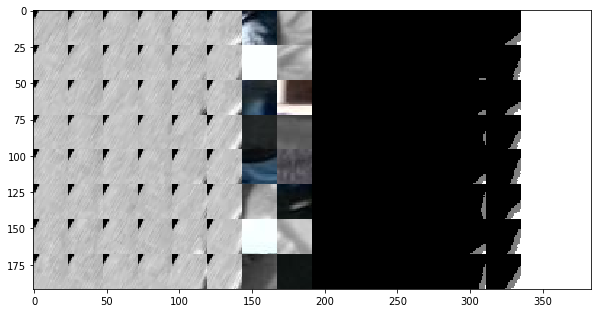

In [8]:

for x,y in data_generator(gmm_loader,1,epoch_size=1):
    draw_sample(x,y,8,8)
    break

In [9]:
import theano

Using cuDNN version 5110 on context None
Mapped name None to device cuda0: GeForce GTX 660 Ti (0000:01:00.0)


In [10]:
from sklearn import mixture
class GMMGradOp(theano.Op):
    def __init__(self, gaussLLHistModel):
        super(GMMGradOp, self).__init__()
        self.gaussLLHistModel = gaussLLHistModel
        self.otypes = [T.fmatrix,T.fvector]
        self.itypes = [T.fmatrix,T.fvector]
        
    def split(self,X,Y):
        p = X[Y < 0.1]
        n = X[Y > 0.9]
        num = self.gaussLLHistModel.sample_num
        return p[:-num],p[-num:],n[:num]
    
    def merge(self, x,yp,yn,Y):
        out = np.zeros((len(Y),x.shape[1]),dtype=np.float32)
        num = self.gaussLLHistModel.sample_num
        out[Y>0.9][:num] = yn
        out[Y <0.1]= np.concatenate((x,yp),axis=0)
        return out
        

    def perform(self, node, (X,Y), output_storage):
        x,yp,yn = self.split(X,Y)
        dX,dY = output_storage[0],output_storage[1]
        fdx,fdyp,fdyn = self.gaussLLHistModel.backward(x,yp,yn)
        dY[0] = np.zeros_like(Y,dtype=np.float32)
        dX[0] = self.merge(fdx,fdyp,fdyn,Y)
        

class GMMOp(theano.Op):
    def __init__(self, gaussLLHistModel):
        super(GMMOp, self).__init__()
        self.gaussLLHistModel = gaussLLHistModel
        self.otypes = [T.scalar]
        self.itypes = [T.fmatrix,T.fvector]

    def split(self,X,Y):
        p = X[Y < 0.1]
        n = X[Y > 0.9]
        num = self.gaussLLHistModel.sample_num
        return p[:-num],p[-num:],n[:num]
    
    def perform(self, node, (X,Y), output_storage):
        z = output_storage[0]        
        x,yp,yn = self.split(X,Y)
        z[0] = self.gaussLLHistModel.forward(x,yp,yn).astype(np.float32)
        
    def grad(self, (X,Y), output_grads):
        return GMMGradOp(self.gaussLLHistModel)(X,Y)
    
    
class GMMAccuracyOp(theano.Op):
    def __init__(self):
        super(GMMAccuracyOp, self).__init__()
        self.otypes = [T.scalar]
        self.itypes = [T.fmatrix,T.fvector]
        
    def gmm_prob(self,Y,means,covars,weights):
        d = Y.shape[1]
        prob = (-.5*d*np.log(2*np.pi)-.5*np.log(covars).sum(1))[None,:]\
                -0.5*((Y[:,None,:]-means[None,])**2/covars[None,:,:]).sum(2)\
                +np.log(weights)[None,:]
        return np.exp(prob).sum(1)
    
    def split(self,X,Y):
        p = X[Y < 0.1]
        n = X[Y > 0.9]
        return p[:len(p)/2],p[:len(p)/2],n

    def build_gmm(self,X, gm_num):
        gmm = mixture.GaussianMixture(covariance_type='diag',n_components=gm_num, max_iter=10000)
        gmm.fit(X)
        return np.copy(gmm.means_), np.copy(gmm.covariances_), np.copy(gmm.weights_)

    def classify(self,X,Y,gm_num):
        Yll = self.gmm_prob(Y,*self.build_gmm(X,gm_num))
        mask = np.zeros_like(Yll)
        mask[Yll > 0.5] = 1.
        return mask

    def accuracy(self,X,Yp,Yn,gm_num):
        cl = self.classify(X,np.concatenate((Yp,Yn)),gm_num)
        return (cl[:len(Yp)].sum()+len(Yn)-cl[len(Yp):].sum())/len(cl)


    def perform(self, node, (X,Y), output_storage):
        z = output_storage[0]        
        x,yp,yn = self.split(X,Y)
        z[0] = self.accuracy(x,yp,yn,5)

In [11]:
import theano.tensor as T
import lasagne
from lasagne import layers as L
from broadcast import BroadcastLayer,UnbroadcastLayer
from lasagne.nonlinearities import rectify
from lasagne.init import HeNormal,Constant

In [12]:
from symbols import make_conv,BroadcastLayer,res_unit

def gen_unet1(data,num_filters,deep,name='unet',first=True):    
    name = name+str(deep)
    res1 = make_conv(data,num_filters,3,name=name+'_in')   
    
    if(deep == 1):
        return res1
    
    res2 = L.Pool2DLayer(res1,2,name=name+'_pool')
    res2 = gen_unet1(res2,num_filters*2,deep-1,name[:-1],False)
    res2 = L.Deconv2DLayer(res2,num_filters*((2**(deep-1))-1),2,2,crop='valid',nonlinearity=None,name=name+'_deconv')
    res2 = L.BatchNormLayer(res2,name=name+'_deconv_bn')
    res2 = L.NonlinearityLayer(res2,rectify,name=name+'_deconv_rectify')
    res = L.ConcatLayer([res2,res1],axis=1, cropping=(None, None, "center", "center"),name=name+'_concat')
    if(first ):
        res = L.Conv2DLayer(res,num_filters*(2**(deep-1)),3,nonlinearity=None,name=name+'_conv',pad='same')
    else:
        res = make_conv(res,num_filters*(2**(deep-1)),3,name=name+'_out')   
    return res


def make_net(input_tensor):
    data_l = L.InputLayer((cfg.SEQ_LENGTH,3,cfg.TILE_SIZE[1],cfg.TILE_SIZE[0])
                           ,input_tensor
                           ,name='data')
    unet = gen_unet1(data_l,6,3,name='unet')
    flatten = BroadcastLayer(unet,(0,2,3))
    return flatten,unet
    

In [13]:
from utils import get_network_str,save_weights,load_weights

data = T.tensor4(name='data')
flatten, net = make_net(data)
print get_network_str(net,incomings=True,outgoings=True)


In -->     Layer    --> Out    Description                         
-------    -----    -------    -----------                         
[]         0        [1]        data(64, 3, 24, 24)                 
[0]        1        [2]        unet3_in_conv(3)(64, 6, 24, 24)     
[1]        2        [3]        unet3_in_bn(64, 6, 24, 24)          
[2]        3        [4, 22]    unet3_in_relu(64, 6, 24, 24)        
[3]        4        [5]        unet3_pool(64, 6, 12, 12)           
[4]        5        [6]        unet2_in_conv(3)(64, 12, 12, 12)    
[5]        6        [7]        unet2_in_bn(64, 12, 12, 12)         
[6]        7        [8, 15]    unet2_in_relu(64, 12, 12, 12)       
[7]        8        [9]        unet2_pool(64, 12, 6, 6)            
[8]        9        [10]       unet1_in_conv(3)(64, 24, 6, 6)      
[9]        10       [11]       unet1_in_bn(64, 24, 6, 6)           
[10]       11       [12]       unet1_in_relu(64, 24, 6, 6)         
[11]       12       [13]       unet2_deconv(64,

In [14]:
import warnings
warnings.filterwarnings('ignore')
from gauss_ll_hist import GaussLLHistModel
gmm = GaussLLHistModel(cfg.SEQ_LENGTH//4*cfg.TILE_SIZE[0]*cfg.TILE_SIZE[1],2,7)

In [15]:
def center_loss(_X,_Y):
    _X = _X/(0.001+T.sqrt(T.sqr(_X).sum(1))[:,None])
    tX = _X[:64*24*24//2]
    tY = 1.-_Y[:64*24*24//2]
    Y = 1.- _Y[64*24*24//2:]
    X = _X[64*24*24//2:]
    center = (tX*tY[:,None]).sum(0)/(0.001+tY.sum())
    Y = 2.*Y-1.
    return (T.sqr(center[None,:]-X)*Y[:,None]).mean()*100.

def center_accuracy(X,Y):
    Tr = X[:len(X)//2][Y[:len(X)//2] < 0.1]
    Xp = X[len(X)//2:][Y[len(X)//2:] < 0.1]
    Xn = X[len(X)//2:][Y[len(X)//2:] > 0.9]
    c = Tr.mean(0)
    d = np.std(Tr,axis=0).sum()
    tp = Xp[np.square(Xp-c).sum(1) < d**2]
    tn = Xn[np.square(Xn-c).sum(1) > d**2]
    return (len(tp)+len(tn))/float(len(Xp)+len(Xn)),d

In [16]:
from lasagne.regularization import regularize_network_params,l2

params = lasagne.layers.get_all_params(net, trainable=True)
X = lasagne.layers.get_output(flatten)
X = X/T.sqrt(T.square(X).sum(1)[:,None])
label = T.tensor3(name='label')
Y = label.flatten()
l2_loss = 1e-4 * regularize_network_params(net, l2)
loss = l2_loss+GMMOp(gmm)(X,Y)#center_loss(X,Y)
G_lr = theano.shared(np.array(0.001, dtype=theano.config.floatX))


MAX_GRAD_NORM = 15
all_grads = T.grad(loss, params)
all_grads = [T.clip(g, -.1, .1) for g in all_grads]
all_grads, norm = lasagne.updates.total_norm_constraint(all_grads, MAX_GRAD_NORM, return_norm=True)
updates = lasagne.updates.adam(all_grads,params,G_lr)


In [17]:
train_fn = theano.function([data, label], [loss,X], allow_input_downcast=True, updates=updates)
print 'train_fn compiled'

train_fn compiled


In [115]:
# accyracy = GMMAccuracyOp()(X,Y)
# test_fn  = theano.function([data, label],[accyracy,X], allow_input_downcast=True)
# print 'test_fn compiled'

In [18]:
G_lr.set_value(np.float32(0.01))

In [19]:
load_weights(net,'models/gmm008_loss-7.60')

In [20]:


for j in range(5,cfg.TRAIN.EPOCH_NUM):
    train_loss=0
    train_acc=0
    for i,batch in enumerate(data_generator(gmm_loader,epoch_size=100)):
        res = train_fn(*batch)
        train_loss+=res[0]
        print '\r epoch %i batch %i loss=%.2f , %.2f'%(j,i,train_loss/float(i+1),res[0]),
    print ''
    save_weights(net,'models/%s%03i_loss%05.2f'%\
                 (cfg.NAME,j,train_loss/float(i+1)))
#     print ''
#     for i,batch in enumerate(data_generator(gmm_loader,epoch_size=10)):
#         res = test_fn(*batch)
#         train_acc+=res[0]
#     print 'accuracy ',res[0]/10

 epoch 5 batch 26 loss=34502178.59 , 30354450.00                         

KeyboardInterrupt: 

# Draw Histogram

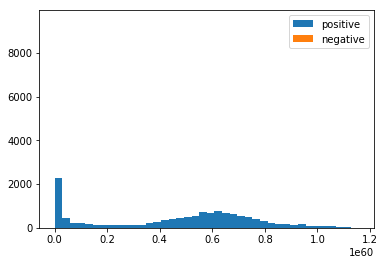

In [110]:
     
def gmm_prob(Y,means,covars,weights):
    d = Y.shape[1]
    prob = (-.5*d*np.log(2*np.pi)-.5*np.log(covars).sum(1))[None,:]\
            -0.5*((Y[:,None,:]-means[None,])**2/covars[None,:,:]).sum(2)\
            +np.log(weights)[None,:]
    return np.exp(prob).sum(1)

def split(X,Y):
    p = X[Y < 0.1]
    n = X[Y > 0.9]
    return p[:len(p)/2],p[:len(p)/2],n

def build_gmm(X, gm_num):
    gmm = mixture.GaussianMixture(covariance_type='diag',n_components=gm_num, max_iter=10000)
    gmm.fit(X)
    return np.copy(gmm.means_), np.copy(gmm.covariances_), np.copy(gmm.weights_)


def build_hist(X,Y,gm_num):
    x,yp,yn = split(X,Y)
    model = build_gmm(x,gm_num)
    p = gmm_prob(yp,*model)
    n = gmm_prob(yn,*model)
    plt.hist(p,bins=40,label='positive')
    plt.hist(n,bins=40,label='negative')
    plt.legend()
    plt.show()
    
for i,batch in enumerate(data_generator(gmm_loader,epoch_size=10)):
    res = train_fn(*batch)
    build_hist(res[1],batch[1].flatten(),2)
    break

In [ ]:
         
def load_weights(network,name ):
    f = np.load(name+".npz")
    params = [f["param%d" % i] for i in range(len(f.files))]
    f.close()
    L.set_all_param_values(network,params)
